# Data Mining Workflow

## Set Up the Jupyter Notebook for Analysis

Note: we have our brand new package called swat - SAS Scripting Wrapper for Analytics Transfer - available on GitHub via pip install

In [1]:
# Import necessary packages and modules
from swat import *
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

# Define directory and data file name
indata_dir = 'data'
indata     = 'hmeq'

# Server, port, username, password
s = CAS('localhost', 5570, authinfo = '~/.authinfo', caslib = 'casuser')

# Push the relevant table In-Memory
## Note, this is a server side data load, not being loaded from the client
if not s.table.tableExists(table=indata).exists:
    s.loadTable(indata_dir + '/' + indata + '.sas7bdat', casout = indata)

ERROR: BASE Data Connector, Invalid path name /home/sasdemo/casuser/data/hmeq.sas7bdat
ERROR: BASE Data Connector failed.
ERROR: The action stopped due to errors.


## Load Actionsets & Set Variable Shortcuts

In [2]:
# Load table actionsets
actionsets = ['cardinality', 'sampling', 'fedSQL', 'decisionTree', 'neuralNet', 'svm', 'astore']
[s.loadactionset(i) for i in actionsets]

# Set variables for later use by models
## For models that can handle missing values
target              = 'BAD'
class_inputs        = ['REASON', 'JOB']
interval_inputs     = ['CLAGE', 'CLNO', 'DEBTINC', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'NINQ', 'DEROG', 'DELINQ']
class_vars          = [target] + class_inputs
all_inputs          = interval_inputs + class_inputs

## For models that can't handle missing values
imp_class_inputs    = ['IMP_' + s for s in class_inputs]
imp_interval_inputs = ['IMP_' + s for s in interval_inputs]
imp_class_vars      = [target] + imp_class_inputs
imp_all_inputs      = imp_interval_inputs + imp_class_inputs

# Models to be performed
models      = ['dt', 'gbt', 'nn', 'svm']
model_names = ['Decision Tree', 'Gradient Boosting', 'Neural Network', 'Support Vector Machine']

NOTE: Added action set 'cardinality'.
NOTE: Added action set 'sampling'.
NOTE: Added action set 'fedSQL'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'neuralNet'.
NOTE: Added action set 'svm'.
NOTE: Added action set 'astore'.


# Data Exploration and Preparation

## Investigate the data

In [3]:
# Print out the first 10 rows of the dataset
s.CASTable(indata).head(10)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1.0,1500.0,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
5,1.0,1700.0,30548.0,40320.0,HomeImp,Other,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614
6,1.0,1800.0,48649.0,57037.0,HomeImp,Other,5.0,3.0,2.0,77.100000,1.0,17.0,NaN
7,1.0,1800.0,28502.0,43034.0,HomeImp,Other,11.0,0.0,0.0,88.766030,0.0,8.0,36.884894
8,1.0,2000.0,32700.0,46740.0,HomeImp,Other,3.0,0.0,2.0,216.933333,1.0,12.0,NaN
9,1.0,2000.0,NaN,62250.0,HomeImp,Sales,16.0,0.0,0.0,115.800000,0.0,13.0,NaN


## Gather Summary Statistics

In [4]:
%%capture
# Create table of summary statistics in SAS
s.cardinality.summarize(
    table = indata, 
    cardinality = dict(name = 'data_card', replace = True)
)

# Modify SAS output table using pandas dataframe manipulation syntax to present summary statistics
df_data_card = s.CASTable('data_card').to_frame()
df_data_card['_PCTMISS_'] = (df_data_card['_NMISS_']/df_data_card['_NOBS_'])*100
df_data_card[['_VARNAME_','_TYPE_','_PCTMISS_','_MIN_','_MAX_','_MEAN_','_STDDEV_','_SKEWNESS_','_KURTOSIS_']].round(2)

,_VARNAME_,_TYPE_,_PCTMISS_,_MIN_,_MAX_,_MEAN_,_STDDEV_,_SKEWNESS_,_KURTOSIS_
0,BAD,N,0.00,0.00,1.00,0.20,0.40,1.50,0.26
1,LOAN,N,0.00,1100.00,89900.00,18607.97,11207.48,2.02,6.93
2,MORTDUE,N,8.69,2063.00,399550.00,73760.82,44457.61,1.81,6.48
3,VALUE,N,1.88,8000.00,855909.00,101776.05,57385.78,3.05,24.36
4,REASON,C,4.23,NaN,NaN,NaN,NaN,NaN,NaN
5,JOB,C,4.68,NaN,NaN,NaN,NaN,NaN,NaN
6,YOJ,N,8.64,0.00,41.00,8.92,7.57,0.99,0.37
7,DEROG,N,11.88,0.00,10.00,0.25,0.85,5.32,36.87
8,DELINQ,N,9.73,0.00,15.00,0.45,1.13,4.02,23.57
9,CLAGE,N,5.17,0.00,1168.23,179.77,85.81,1.34,7.60


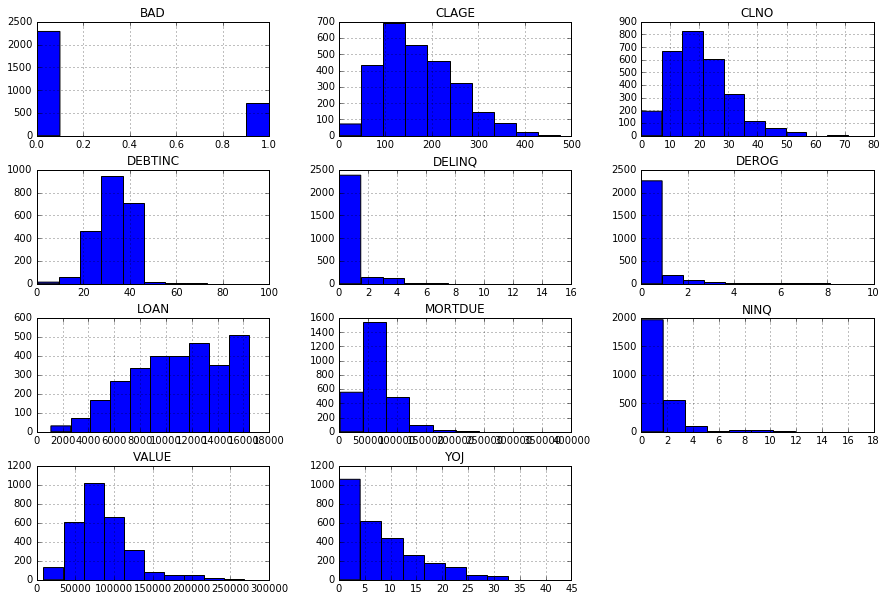

In [5]:
# Use the built in hist() method to plot the distribution of every variable
s.CASTable(indata).hist(figsize = (15, 10));

## Plot Missing Values

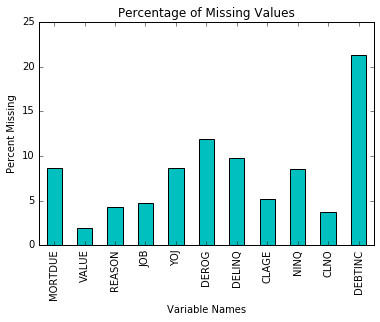

In [6]:
# Plot missing values in matplotlib
df_data_miss = df_data_card[df_data_card['_PCTMISS_'] > 0]
tbl_forplot  = pd.Series(list(df_data_miss['_PCTMISS_']), index = list(df_data_miss['_VARNAME_']))
ax = tbl_forplot.plot(
    kind  = 'bar',
    title = 'Percentage of Missing Values', 
    color = 'c')
ax.set_ylabel('Percent Missing')
ax.set_xlabel('Variable Names');

## Perform Imputation on Missing Values

In [7]:
# Impute missing values
s.CASTable(indata).dataPreprocess.transform(
    outVarsNameGlobalPrefix = 'IMP',
    requestPackages = [
        dict(impute = 'MEAN',     inputs = ['clage', 'mortdue', 'loan']),
        dict(impute = 'MEDIAN',   inputs = ['delinq', 'value', 'clno']),
        dict(impute = 'RANDOM',   inputs = ['ninq', 'derog']),
        dict(impute = 'MODE',     inputs = ['reason', 'job']),
        dict(impute = 'MIDRANGE', inputs = ['debtinc', 'yoj']),
    ],
    copyAllVars = True,
    casOut = dict(name = indata, replace = True)
)

# Print the first five rows with imputations
s.CASTable(indata).head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,...,IMP_DEBTINC,IMP_DELINQ,IMP_DEROG,IMP_LOAN,IMP_MORTDUE,IMP_NINQ,IMP_VALUE,IMP_YOJ,IMP_JOB,IMP_REASON
0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,...,101.918324,0.0,0.000000,1100.0,25860.0000,1.000000,39025.0,10.5,Other,HomeImp
1,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,...,101.918324,2.0,0.000000,1300.0,70053.0000,0.000000,68400.0,7.0,Other,HomeImp
2,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,...,101.918324,0.0,0.000000,1500.0,13500.0000,1.000000,16700.0,4.0,Other,HomeImp
3,1.0,1500.0,NaN,NaN,,,NaN,NaN,NaN,NaN,...,101.918324,0.0,0.655082,1500.0,73760.8172,6.164712,89235.5,20.5,Other,DebtCon
4,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,...,101.918324,0.0,0.000000,1700.0,97800.0000,0.000000,112000.0,3.0,Office,HomeImp


## Partition Data into Training and Validation Sets

In [8]:
%%capture
# Create a 70/30 split
s.sampling.stratified(
    table   = dict(name = indata, groupBy = target),
    samppct = 70,
    partind = True,
    seed    = 12345,
    output  = dict(casOut = dict(name = indata, replace = True), copyVars = 'ALL')
)

# Verify the partition worked properly using SQL
s.fedSQL.execDirect('''
    SELECT 
        CASE WHEN _PartInd_ = 1 THEN 'Training' ELSE 'Validation' END AS name,
        _PartInd_,
        COUNT(*) AS obs
    FROM ''' + indata + '''
    GROUP BY 
        _PartInd_,
        CASE WHEN _PartInd_ = 1 THEN 'Training' ELSE 'Validation' END
    ORDER BY _PartInd_ DESC;
''')

,NAME,_PartInd_,OBS
0,Training,1.0,4172.0
1,Validation,0.0,1788.0


# Build Models

### Set keyword argument shortcuts

In [9]:
# For models that can handle missing values (decision tree, gradient boosting)
params = dict(
    table    = dict(name = indata, where = '_partind_ = 1'), 
    target   = target, 
    inputs   = all_inputs, 
    nominals = class_vars,
)

# For models that can't have missing values (neural network, support vector machine)
imp_params = dict(
    table    = dict(name = indata, where = '_partind_ = 1'), 
    target   = target, 
    inputs   = imp_all_inputs, 
    nominals = imp_class_vars,
)

## Decision Tree

In [10]:
s.decisionTree.dtreeTrain(**params, varImp = True, casOut = dict(name = 'dt_model', replace = True))

,Descr,Value
0,Number of Tree Nodes,17.000000
1,Max Number of Branches,2.000000
2,Number of Levels,6.000000
3,Number of Leaves,9.000000
4,Number of Bins,20.000000
5,Minimum Size of Leaves,6.000000
6,Maximum Size of Leaves,3217.000000
7,Number of Variables,12.000000
8,Confidence Level for Pruning,0.250000
9,Number of Observations Used,4172.000000


## Gradient Boosting

In [11]:
s.decisionTree.gbtreeTrain(**params, casOut = dict(name = 'gbt_model', replace = True))

,Descr,Value
0,Number of Trees,50.0
1,Distribution,2.0
2,Learning Rate,0.1
3,Subsampling Rate,0.5
4,Number of Selected Variables (M),12.0
5,Number of Bins,20.0
6,Number of Variables,12.0
7,Max Number of Tree Nodes,63.0
8,Min Number of Tree Nodes,19.0
9,Max Number of Branches,2.0


## Neural Network

In [12]:
s.neuralNet.annTrain(**imp_params, casOut = dict(name = 'nn_model', replace = True))

,Progress,Objective,Loss
0,1.0,3.087913,3.087913
1,2.0,1.776390,1.776390
2,3.0,1.353845,1.353845
3,4.0,1.285758,1.285758
4,5.0,1.253823,1.253823
5,6.0,1.244164,1.244164
6,7.0,1.241971,1.241971
7,8.0,1.239929,1.239929
8,9.0,1.239515,1.239515
9,10.0,1.238887,1.238887


## Support Vector Machine

In [13]:
s.svm.svmTrain(**imp_params, kernel = 'polynomial', id = [target, '_partind_'], savestate = 'svm_model')

NOTE: Reset degree to 2 for polynomial kernel.
NOTE: SVM training is activated.
NOTE: Wrote 10525 bytes to the savestate file svm_model.


,Descr,Value
0,Task Type,C_CLAS
1,Optimization Technique,Interior Point
2,Scale,YES
3,Kernel Function,Polynomial
4,Kernel Degree,2
5,Penalty Method,C
6,Penalty Parameter,1
7,Maximum Iterations,25
8,Tolerance,1e-06
,Descr,N


# Model Comparison

## Score the Models on Validation Data

In [16]:
%%capture
def score_model(model):
    return dict(
        table      = indata,
        modelTable = model + '_model',
        copyVars   = [target, '_partind_'],
        casOut     = dict(name = '_scored_' + model, replace = True)
    )

### Decision Tree
s.decisionTree.dtreeScore(**score_model('dt'))

### Gradient Boosting
s.decisionTree.gbtreeScore(**score_model('gbt'))

### Neural Network
s.neuralNet.annScore(**score_model('nn'))

### Support Vector Machine
s.CASTable(indata).astore.score(rstore  = 'svm_model', out = dict(name = '_scored_svm', replace = True))

### Create standardized prediction column
for i in range(len(models)-1):
    s.dataStep.runCode('''
        data _scored_''' + models[i] + '''; 
            set _scored_''' + models[i] + '''; 
            if _''' + models[i] + '''_predname_ = 1
                then p_''' + target + '''1 = _''' + models[i] + '''_predp_; 
                else p_''' + target + '''1 = 1 - _''' + models[i] + '''_predp_;
        run;
    ''')

## Assess the Performance

In [17]:
# Model assessment function
def assess_model(model):
    return s.percentile.assess(
        table    = dict(name = '_scored_' + model, where = '_partind_ = 0'),
        inputs   = 'p_' + target + '1',      
        response = target,
        event    = '1',   
    )

# Initialize assessment dataframes
roc_df  = pd.DataFrame()

# Loop through the models and append to the appropriate dataframe
for i in range(len(models)):
    tmp = assess_model(models[i])
    tmp.ROCInfo['Model']  = model_names[i]
    roc_df  = pd.concat([roc_df,  tmp.ROCInfo])

print('\n', 'Confusion Matrix Information'.center(42, ' '))
roc_df[round(roc_df['CutOff'], 2) == 0.5][['Model', 'TP', 'FP', 'FN', 'TN']].reset_index(drop = True)

ERROR: The file or path '_scored_svm' is not available in the file system.
ERROR: Table '_scored_svm' could not be loaded.
ERROR: Failure opening table '_scored_svm': A table could not be loaded.
ERROR: The action stopped due to errors.


AttributeError: 'CASResults' object has no attribute 'ROCInfo'

## Compare Misclassification Rates

In [16]:
# Add misclassification rate calculation
roc_df['Misclassification'] = 1 - roc_df['ACC']

print('\n', 'Misclassification Rate Comparison'.center(37, ' '))
roc_df[round(roc_df['CutOff'], 2)==0.5][['Model', 'Misclassification']].sort_values('Misclassification').reset_index(drop = True)


   Misclassification Rate Comparison  


,Model,Misclassification
0,Gradient Boosting,0.095638
1,Decision Tree,0.124161
2,Neural Network,0.128635
3,Support Vector Machine,0.130872


## Create ROC Curve

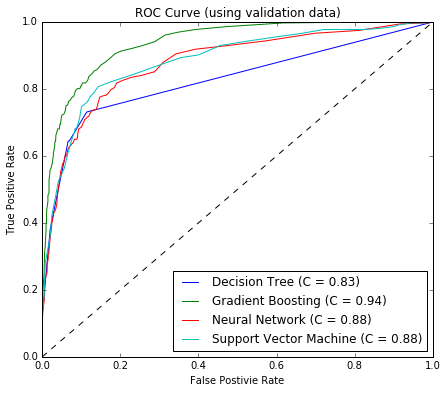

In [17]:
# Plot ROC curve
plt.figure(figsize = (7, 6))
for key, grp in roc_df.groupby(['Model']):
    plt.plot(grp['FPR'], grp['Sensitivity'], label = key + ' (C = %0.2f)' % grp['C'].mean())
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curve (using validation data)')
plt.show();

## Compare Python Scikit-Learn Gradient Boosting

In [18]:
# Pull data to client (note: Python models must be run locally)
local = s.CASTable(indata).to_frame()

# Create dummy variables for class inputs (note: scikit-learn cannot have character variables)
local = pd.concat([local, pd.get_dummies(local[imp_class_inputs], drop_first = False)], axis = 1)

# Split into training and validation
train = local[local['_PartInd_']==1]
valid = local[local['_PartInd_']==0]

# Split target and inputs and remove unnecessary variables (note: scikit-learn Gradient Boosting can't handle missing values)
X_train = train.drop(class_vars + imp_class_vars + interval_inputs + ['_PartInd_'], axis = 1)
X_valid = valid.drop(class_vars + imp_class_vars + interval_inputs + ['_PartInd_'], axis = 1)
y_train = train[target]
y_valid = valid[target]

# Build scikit-learn gradient boosting model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics  import confusion_matrix, accuracy_score
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
df = pd.DataFrame(dict(actual = y_valid, pred = gb.predict_proba(X_valid)[:,1])) # put results in pandas dataframe

# Predict and assess model
gb_y_score           = gb.predict(X_valid)
gb_misclassification = 1 - accuracy_score(y_valid, gb_y_score)
gb_confusion_matrix  = confusion_matrix(y_valid, gb_y_score)

print('Confusion Matrix\n', gb_confusion_matrix, '\n') # note: scikit-learn reverses True Positives and True Negatives
print('Misclassification Rate\n ', gb_misclassification)

Confusion Matrix
 [[1355   76]
 [ 114  243]] 

Misclassification Rate
  0.106263982103


## Promote Python model results to CAS to assess

In [19]:
import swat.cas.datamsghandlers as dmh
s.addtable(table = 'Python', **dmh.PandasDataFrame(df).args.addtable, replace=True) # promote to CAS

# Assess the Python model using CAS
python_assess = s.percentile.assess(
    table    = 'Python',
    inputs   = 'pred',      
    response = 'actual',
    event    = '1',   
)
python_assess.ROCInfo['Model']  = 'Gradient Boosting - Python'
roc_df['Model'] = roc_df['Model'] + ' - CAS'
roc_df = pd.concat([roc_df.query('Model == "Gradient Boosting - CAS"'),  python_assess.ROCInfo])

# Verify that the Python actuals vs. predicted are in CAS
s.CASTable('Python').fetch(to = 5)

,actual,pred
0,1.0,0.897335
1,1.0,0.836228
2,1.0,0.929580
3,0.0,0.534590
4,1.0,0.966328


## Compare ROC Curves

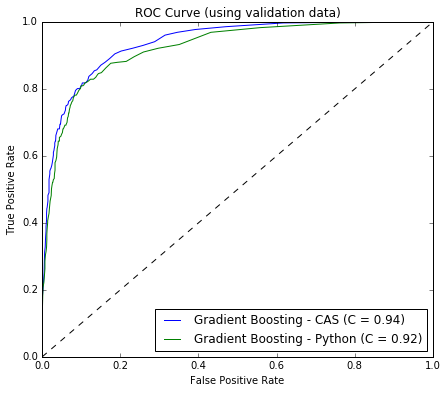

In [20]:
# Plot ROC curve
plt.figure(figsize = (7, 6))
for key, grp in roc_df.groupby(['Model']):
    plt.plot(grp['FPR'], grp['Sensitivity'], label=key + ' (C = %0.2f)' % grp['C'].mean())
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curve (using validation data)');    

# Deploy the CAS Gradient Boosting Model

In [21]:
# Generate the score code that can be leveraged by Model Manager
unload = s.save('gbt_model', name = 'gbt_scorecode', replace = True)

NOTE: Cloud Analytic Services saved the file gbt_scorecode.sashdat in caslib DMlib.


In [22]:
s.close() #close the session